In [1]:
import numpy as np 
import pandas as pd
from keras.layers import Dense, Embedding, Input
from keras.layers import LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing import text, sequence
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.callbacks import EarlyStopping, ModelCheckpoint
max_features = 20000
maxlen = 100

train = pd.read_csv("obscene0.csv")
train = train.sample(frac=1)
list_sentences_train = train["comment_text"].fillna("").values
#list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train["obscene"].values

Using TensorFlow backend.


In [2]:
#Tokenize 
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(
   list_tokenized_train, y, test_size=0.50, random_state=42)

In [4]:
#Padding
X_t = sequence.pad_sequences(X_train, maxlen=maxlen)
X_v = sequence.pad_sequences(X_valid, maxlen=maxlen)

In [5]:
from keras.models import Model, Sequential
def get_model():
    embed_size = 128
    model = Sequential()
    model.add(Embedding(max_features, embed_size, input_length=maxlen))
    model.add(LSTM(100, input_shape=(embed_size, 1)))
    model.add(Dropout(0.1))
    model.add(Dense(50, activation="relu",kernel_initializer='he_normal'))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [8]:
model = None
list_sentences_train
model = get_model()
batch_size = 32
epochs = 3
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)
callbacks_list = [early]
model.fit(X_t, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.10, callbacks=callbacks_list)

Train on 7806 samples, validate on 868 samples
Epoch 1/3
 224/7806 [..............................] - ETA: 54s - loss: 0.6924 - acc: 0.5134

KeyboardInterrupt: 

In [9]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 2,656,701
Trainable params: 2,656,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test = model.predict(X_v)

In [26]:
prob_toxic = []
y_valid_toxic = []
for i in range(len(y_test)):
    prob_toxic.append(y_test[i])
    y_valid_toxic.append(y_valid[i])

from sklearn import metrics as mtr
fpr, tpr, thresholds = mtr.roc_curve(y_valid_toxic, prob_toxic)

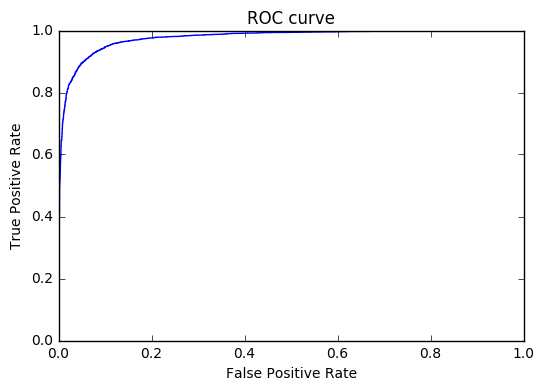

In [27]:
from matplotlib import pyplot as plt
plt.plot(fpr, tpr)
plt.title("ROC curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

In [28]:
mtr.roc_auc_score(y_valid_toxic, prob_toxic)

0.976898543281787